## 1. Import Library 
___

### Install EfficientDet Library

In [1]:
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch

  Preparing metadata (setup.py) ... done


In [2]:
import os 
import sys
import pickle
import random
import gc
import ctypes
import copy
from collections import defaultdict

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from PIL import Image
import cv2

import torch; import timm
print(f'{Fore.BLUE} => Pytorch Version: ', torch.__version__)
print(f'{Fore.BLUE} => Timm Version: ', timm.__version__)
import torch.nn as nn
from torch.cuda import amp
import torch.functional as F
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## EfficientDet Library
from effdet.efficientdet import EfficientDet, HeadNet, BiFpn
from effdet.bench import DetBenchTrain, DetBenchPredict
# default config: tf_efficientdet_d1
from effdet.config import get_efficientdet_config, default_detection_model_configs
from effdet.config import default_detection_train_config, get_fpn_config

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import warnings
warnings.filterwarnings('ignore')

print(f'{Fore.BLUE} => Installed Necessary Library')

 => Pytorch Version:  2.5.1+cu121
 => Timm Version:  1.0.12


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 => Installed Necessary Library


### Configuration

In [3]:
class CFG:
    output_dir = 'runs/detect'
    seed = 2025

    img_size = [256, 256]
    imgdir = '/kaggle/input/gastroscopy-256x256-resized-png'
    model_name = 'tf_efficientdet_d0'
    num_classes = 3 # Ulcer, Polyp, Cancer

    num_epochs = 20
    train_bs = 16
    valid_bs = train_bs * 2 
    scheduler_type = 'CosineAnnealingLR' # ReduceLROnPlateau, CosineAnnealingWarmRestarts
    base_lr = 1e-3
    min_lr = 1e-9
    weight_decay = 1e-5
    T_mult = 1
    
    n_accumulate = 1 ## Gradient Accumulation
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_count = torch.cuda.device_count()

print('Device is', CFG.device)
print('Num GPU of machine is', CFG.device_count)

Device is cuda
Num GPU of machine is 1


### Reproducibility

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

### Clean_memory

In [5]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

## 2. Utils
___

**draw_bbox**

In [6]:
def draw_bbox(image, box, label_name, label_id, color):
    alpha_text = 0.8 # text box color
    thickness = 2
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(str(label_id) + ' ' + label_name.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    # Adding Text Box
    cv2.rectangle(overlay_text, (box[0],box[1]-text_height-5),
                  (box[0]+text_width, box[1]), color, -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1-alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2],box[3]), color, thickness)
    cv2.putText(output, str(label_id) + ' ' + label_name.upper(), (box[0], box[1]-3),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

    return output

**AverageMeter**

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

**Collate_fn**

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

## 3. Build Dataset
___

In [9]:
df = pd.read_csv('/kaggle/input/gastroscopy-meta/gastroscopy_data2.csv')
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (2915, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,763.829787,365.957447,1304.255319,748.936170,ulcer
1,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,1148.936170,897.872340,1421.276596,1082.978723,ulcer
2,1_1_00014.png,2048,2048,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,521.276596,561.702128,1078.723404,1225.531915,ulcer
3,1_1_00017.png,2048,2048,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,884.595745,502.127660,1376.085106,753.191489,ulcer
4,1_1_00018.png,2048,2048,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,1161.191489,382.978723,1654.808511,1074.468085,ulcer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,1_2_05234.png,2048,2048,gastroscopy,1,1,polygon,"1115.23,604.26;1066.30,604.26;1021.62,608.51;9...",rectangle,864.170213,604.255319,1506.723404,1340.425532,polyp
2911,1_2_05235.png,2048,2048,gastroscopy,1,1,polygon,"1138.64,1036.17;1096.09,1068.09;1064.17,1102.1...",rectangle,949.276596,1019.148936,1528.000000,1542.553191,polyp
2912,1_2_05236.png,2048,2048,gastroscopy,1,1,polygon,"619.49,529.79;583.32,555.32;553.53,591.49;532....",rectangle,523.744681,519.148936,766.297872,789.361702,polyp
2913,1_2_05236.png,2048,2048,gastroscopy,1,1,polygon,"672.68,1342.55;630.13,1355.32;606.72,1393.62;6...",rectangle,602.468085,1342.553191,759.914894,1493.617021,polyp


None


In [10]:
## 궤양(Ulcer): 1
## 용종(Polyp): 2
## 암(Cancer): 3


df['lesion_label'] = df['lesion_label'] + 1

In [11]:
train_id = [x.split('/')[-1] for x in glob('/kaggle/input/gastroscopy-256x256-resized-png/train/*.png')] 
test_id = [x.split('/')[-1] for x in glob('/kaggle/input/gastroscopy-256x256-resized-png/test/*.png')] 

train_df = df[df['image_id'].isin(train_id)].reset_index(drop=True)
test_df = df[df['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())
print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Train:  1597
=> Number of Unique Image_id in Test:  400


In [12]:
gkf = GroupKFold(n_splits=5)

for i, (_, val_idx) in enumerate(gkf.split(train_df, groups=train_df['image_id'])):
    train_df.loc[val_idx, 'fold'] = i

valid_df = train_df[train_df['fold'] == 0].reset_index(drop=True)
train_df = train_df[train_df['fold'] != 0].reset_index(drop=True)

print('Images in train_df: ', train_df['image_id'].nunique())
print('Images in valid_df: ', valid_df['image_id'].nunique())

Images in train_df:  1279
Images in valid_df:  318


In [13]:
def get_train_transform():
    return A.Compose(
        [A.HorizontalFlip(p=0.5),
         A.Resize(*CFG.img_size, p=1.0),
         ],
         bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

def get_valid_transform():
    return A.Compose(
        [A.Resize(*CFG.img_size, p=1.0),
         ],
        bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


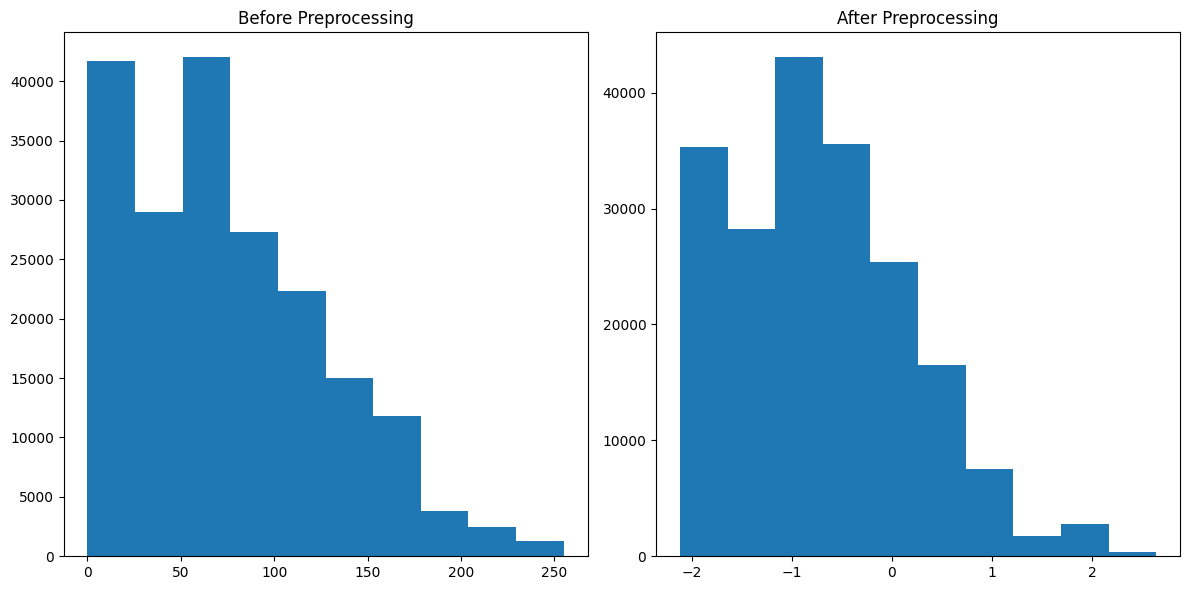

In [14]:
!pip install -q efficientnet

from efficientnet.keras import preprocess_input

path = '/kaggle/input/gastroscopy-256x256-resized-png/train/1_1_00011.png'
img = Image.open(path)
img = np.array(img)
img_preprocessed = preprocess_input(img)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Before Preprocessing')
plt.hist(img.flatten())

plt.subplot(1,2,2)
plt.title('After Preprocessing')
plt.hist(img_preprocessed.flatten())

plt.tight_layout()
plt.show()

In [15]:
### Bbox Format: Ymin, Xmin, Ymax, Xmax
### Image Preprocessing: Normalization

class GastroscopyDataset(Dataset):
    def __init__(self, df, image_dir=None, mode='train', transforms=None, mixup_prob=0.0, mosaic_prob=0.0):
        super(GastroscopyDataset).__init__()

        self.image_ids = df['image_id'].unique()
        self.df = df
        self.mode = mode
        self.image_dir = image_dir
        self.transforms = transforms
        self.mixup_prob = mixup_prob
        self.mosaic_prob = mosaic_prob

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]

        if np.random.rand() <= self.mixup_prob:
            image, boxes, labels = self.load_mu_image_and_boxes(index)
            image = preprocess_input(image)
            image = torch.tensor(image.transpose(2,0,1).astype(np.float32))
            
            target= {}
            target['boxes'] = torch.tensor(boxes).to(torch.float32)
            target['labels'] = torch.tensor(labels).to(torch.int64)
            target['image_id'] = torch.tensor([index])
    
            ## xmin, ymin, xmax, ymax => ymin, xmin, ymax, xmax
            target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]

        elif np.random.rand() <= self.mosaic_prob:
            image, boxes, labels = self.load_mo_image_and_boxes(index)
            
            transform = A.Compose([A.Resize(*CFG.img_size, p=1.0),], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels']))
            sample = transform(image=image, bboxes=boxes, labels=labels)
            
            image = sample['image']; boxes = sample['bboxes']; labels = sample['labels']
            image = preprocess_input(image)
            image = torch.tensor(image.transpose(2,0,1).astype(np.float32))
            
            target= {}
            target['boxes'] = torch.tensor(boxes).to(torch.float32)
            target['labels'] = torch.tensor(labels).to(torch.int64)
            target['image_id'] = torch.tensor([index])
    
            ## xmin, ymin, xmax, ymax => ymin, xmin, ymax, xmax
            target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]

        else:
            image, boxes, labels = self.load_image_and_boxes(index)

            target= {}
            target['boxes'] = torch.tensor(boxes).to(torch.float32)
            target['labels'] = torch.tensor(labels).to(torch.int64)
            target['image_id'] = torch.tensor([index])

            if self.transforms:
               sample = self.transforms(image=image, bboxes=boxes, labels=labels)

               if len(sample['bboxes']) > 0:
                  image = sample['image']
                  image = preprocess_input(image)
                  image = torch.tensor(image.transpose(2,0,1).astype(np.float32))
                  target['boxes'] = torch.tensor(sample['bboxes']).to(torch.float32)
                  target['labels'] = torch.tensor(sample['labels']).to(torch.int64)
                  # Xmin, Ymin, Xmax, Ymax => Ymin, Xmin, Ymax, Xmax
                  target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]
               else: 
                  image = preprocess_input(image)
                  image = torch.tensor(image.transpose(2,0,1).astype(np.float32))
                  target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]

        
        if self.mode == 'train':
            return image, target, image_id
        else:
            return image, image_id

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        path = os.path.join(f'{self.image_dir}', 'train', image_id)
        image = Image.open(path).resize((CFG.img_size[0], CFG.img_size[1]))
        image = np.array(image)
        resized_height, resized_width = image.shape[:2]
        
        ## FillNan
        m = np.nanmean(image)
        image = np.nan_to_num(image, nan=m)

        image = A.Compose([A.CLAHE(clipLimit=(1.5,1.5), tileGridSize=(8,8), p=1.0)])(image=image)['image']
        
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes[:,[0,2]] *= resized_width / records['width'].values[0] 
        boxes[:,[1,3]] *= resized_height / records['height'].values[0]
        
        labels = records['lesion_label'].values

        return image, boxes, labels

    def load_mu_image_and_boxes(self, index):        
        image, boxes, labels = self.load_image_and_boxes(index)
        mu_image, mu_boxes, mu_labels = self.load_image_and_boxes(np.random.randint(0, len(self.image_ids), 1).item())
        
        lam = np.random.beta(2.0,2.0)
        mu_image = (image*lam + mu_image*(1-lam)).astype(np.uint8)
        mu_boxes = np.concatenate([boxes, mu_boxes], axis=0)
        mu_labels = np.concatenate([labels, mu_labels], axis=0) 

        return mu_image, mu_boxes, mu_labels

    def load_mo_image_and_boxes(self, index):
        image, boxes, labels = self.load_image_and_boxes(index)
        im_h, im_w = image.shape[:2]
        resized_w = random.randint(int(CFG.img_size[0]*0.75), int(CFG.img_size[0]*1.25))
        resized_h = random.randint(int(CFG.img_size[1]*0.75), int(CFG.img_size[1]*1.25))
        image = cv2.resize(image, (resized_w, resized_h))
        boxes[:,[0,2]] *= resized_w / im_w
        boxes[:,[1,3]] *= resized_h / im_h

        random_indices = np.random.randint(0, len(self.image_ids), 3)
        mo_images = []
        mo_boxes = []
        mo_labels = []

        resize_list = [
            [(im_w*2-resized_w),resized_h], [resized_w,(im_h*2-resized_h)], [(im_w*2-resized_w),(im_h*2-resized_h)],
        ]
        
        for i in range(3):
            mo_image, mo_bbox, mo_label = self.load_image_and_boxes(random_indices[i])
            mo_h, mo_w = mo_image.shape[:2]
            mo_image = cv2.resize(mo_image, (resize_list[i][0], resize_list[i][1]))
            mo_images.append(mo_image); mo_labels.append(mo_label)
            
            mo_bbox[:,[0,2]] *= resize_list[i][0] / mo_w
            mo_bbox[:,[1,3]] *= resize_list[i][1] / mo_h
            mo_boxes.append(mo_bbox)
             
        
        images = [image] + mo_images
        boxes = [boxes] + mo_boxes
        labels = [labels] + mo_labels

        heights = [i.shape[0] for i in images] 
        widths =  [i.shape[1] for i in images]

        ch = max(heights[0], heights[1])
        cw = max(widths[0], widths[2]) 
        h = (max(heights[0], heights[1]) + 
             max(heights[2], heights[3]))
        w = (max(widths[0], widths[2]) +
             max(widths[1], widths[3]))
        
        # pad or start coordinates 
        y0, x0 = ch - heights[0], cw - widths[0] # Height: 0,  Width: 0 
        y1, x1 = ch - heights[1], cw # Height: 0, Width: 256 
        y2, x2 = ch, cw - widths[2] # Height: 256, Width: 0
        y3, x3 = ch, cw # Height: 256, Width: 256
        x_pads = [x0, x1, x2, x3]
        y_pads = [y0, y1, y2, y3]

        output = np.zeros((h,w,3)).astype(np.uint8)
        for i, img in enumerate(images):
            output[y_pads[i]: y_pads[i] + heights[i],
                   x_pads[i]: x_pads[i] + widths[i],
                   :] = img
        
        new_boxes = []
        for i, bbox in enumerate(boxes):
            bbox += np.array([x_pads[i], y_pads[i], x_pads[i], y_pads[i]])
            new_boxes.append(bbox)

        mo_image = output
        mo_boxes = np.vstack(new_boxes)
        mo_labels = np.concatenate(labels)

        return mo_image, mo_boxes, mo_labels

In [16]:
train_dataset = GastroscopyDataset(
         df = train_df, 
         image_dir = CFG.imgdir,
         transforms = get_train_transform()
)

valid_dataset = GastroscopyDataset(
         df = valid_df,
         image_dir = CFG.imgdir,
         transforms = get_valid_transform()
)

## 3. Visualization Gastroscopy Augmentation
___

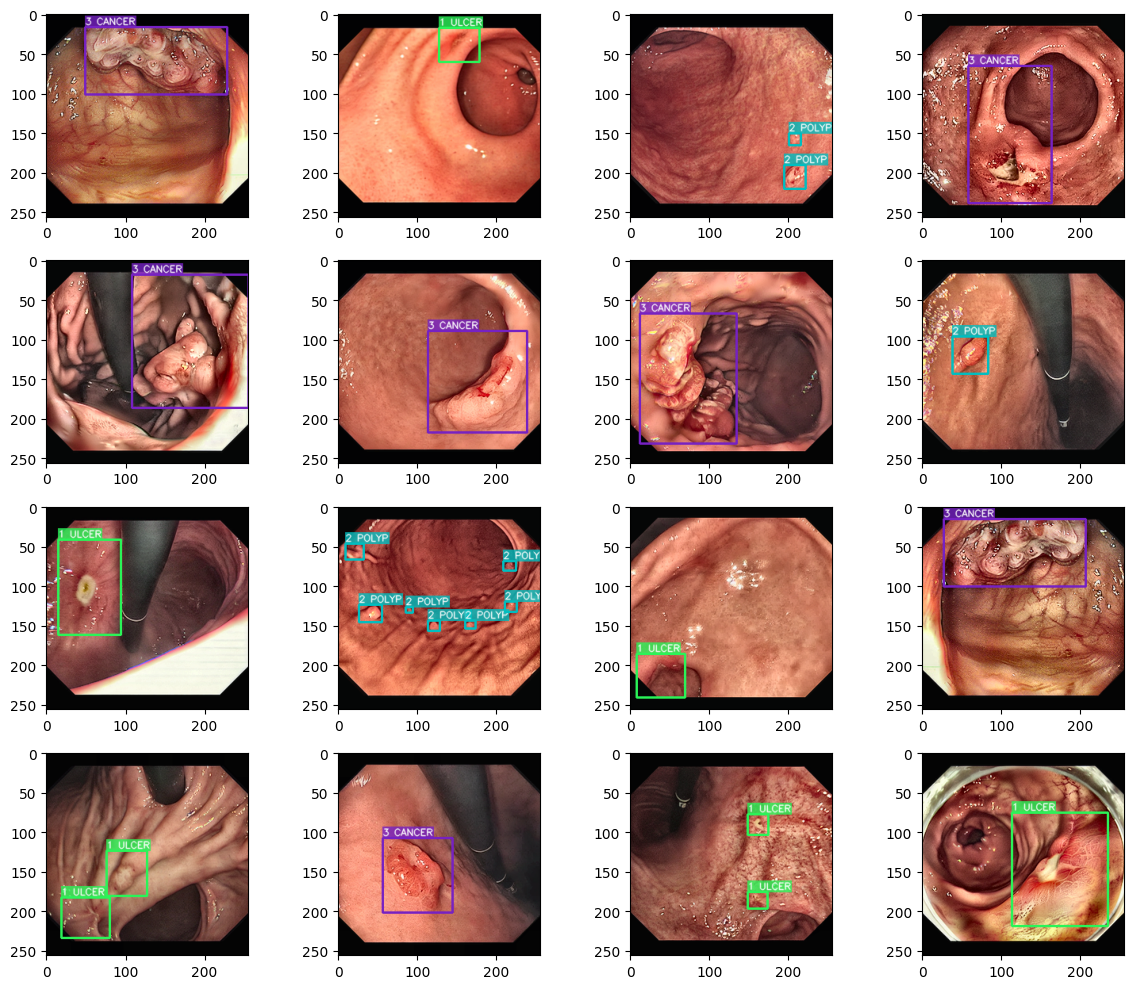

In [17]:
classes = {1: 'Ulcer', 2: 'Polyp', 3: 'Cancer'}

label2color = [[random.randint(0,255) for i in range(3)] for _ in range(CFG.num_classes)]

plt.style.use('default')
plt.figure(figsize=(12,10))

for i in range(16):
    j = np.random.randint(0, len(train_dataset), 1)[0]
    image, target, image_id = train_dataset[j]
    img = image.permute(1,2,0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean
    
    img = (img*255).astype('uint8')
    boxes = target['boxes'].cpu().numpy()
    boxes[:,[0,1,2,3]] = boxes[:,[1,0,3,2]]
    labels = target['labels'].cpu().numpy()

    plt.subplot(4,4,i+1)
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id], label_id, color)
        plt.imshow(img)
        #plt.axis('off')
    clean_memory()
    del image, target, image_id
        
plt.tight_layout()
plt.show()

## 4. Build Trainer Engine
___

**Scheduler**

In [18]:
def fetch_scheduler(scheduler_type, optimizer, loader):
    if scheduler_type == 'ReduceLROnPlateau':  
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', verbose=False, factor=0.1, patience=5, threshold=1e-3,
            threshold_mode='abs', min_lr = CFG.min_lr
        )
        return scheduler
        
    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=CFG.num_epochs*len(loader), eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
        )
        return scheduler
        
    elif scheduler_type == 'CosineAnnealingWarmRestarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0 = CFG.num_epochs*len(loader)//3, T_mult=CFG.T_mult, eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
        )
        return scheduler
        
    else:
        return None

**Build_model**

In [19]:
def build_model():
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes
    config.image_size = CFG.img_size
    config.max_det_per_image = 100

    net = EfficientDet(config, pretrained_backbone=True)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, create_labeler=True)

In [20]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, device, num_epochs, output_dir):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_epochs = num_epochs

        self.history = defaultdict(list)
        self.summary_loss = AverageMeter(); self.box_loss = AverageMeter(); self.class_loss = AverageMeter()
        self.val_summary_loss = AverageMeter(); self.val_box_loss = AverageMeter(); self.val_class_loss = AverageMeter()
        
        self.best_loss = 10**5
        self.best_epoch = 0
        
        self.output_dir = output_dir
        
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir, exist_ok=True)
            
        print(f'{Fore.BLUE} ### Trainer Prepared, Device is {self.device}')
    
    def fit(self, train_loader, valid_loader):

        for epoch in range(1, self.num_epochs + 1):
            print(f'{Fore.BLUE}#'*25)
            print(f'{Fore.BLUE}### Epoch {epoch}/{self.num_epochs}')
            print(f'{Fore.BLUE}#'*25)

            train_loss = self.train_one_epoch(train_loader)
            valid_loss = self.valid_one_epoch(valid_loader)

            print(f'{Fore.BLUE}Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
            
            self.model.eval()
            last_model_wts = copy.deepcopy(self.model.model.state_dict())
            torch.save(last_model_wts, f'{self.output_dir}/last-checkpoint.bin')

            if valid_loss <= self.best_loss:
                self.best_loss = valid_loss
                self.best_epoch = epoch
                best_model_wts = copy.deepcopy(self.model.model.state_dict())

                torch.save(best_model_wts, f'{self.output_dir}/best-checkpoint.bin')
            
            self.model.model.load_state_dict(torch.load(f'{self.output_dir}/best-checkpoint.bin'))

        return self.model, self.history

    
    def train_one_epoch(self, train_loader):
        self.model.train()

        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Training')

        for step, (images, targets, image_ids) in pbar:
            images = torch.stack(images) ## Adding Batch Dimensional
            images = images.to(self.device).float()
            batch_size = images.size(0)

            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels

            output = self.model(images, target_res)

            loss = output['loss']; self.summary_loss.update(loss.detach().item(), batch_size)
            cls_loss = output['class_loss']; self.class_loss.update(cls_loss.detach().item(), batch_size)
            bx_loss = output['box_loss']; self.box_loss.update(bx_loss.detach().item(), batch_size)
            
            
            (loss / CFG.n_accumulate).backward()

            if (step + 1) % CFG.n_accumulate == 0:
            
               self.optimizer.step()

               self.optimizer.zero_grad()

               if CFG.scheduler_type == 'ReduceLROnPlateau': 
                   self.scheduler.step(metrics=self.summary_loss.avg)
               else:
                   self.scheduler.step()

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

            self.history['total_loss'].append(self.summary_loss.avg)
            self.history['box_loss'].append(self.box_loss.avg)
            self.history['class_loss'].append(self.class_loss.avg)
            self.history['LR'].append(self.optimizer.param_groups[0]["lr"])
        
            pbar.set_postfix(
                  total_loss = f'{self.summary_loss.avg:.5f}',
                  cls_loss = f'{self.class_loss.avg:.5f}', 
                  box_loss = f'{self.box_loss.avg:.5f}',
                  lr = f'{self.optimizer.param_groups[0]["lr"]:.9f}',
                  gpu_mem = f'{mem} GB'
             )
        
        torch.cuda.empty_cache()
        clean_memory()
        
        return self.summary_loss.avg

    @torch.no_grad()
    def valid_one_epoch(self, valid_loader):
        self.model.eval()

        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation')
        for step, (images, targets, image_ids) in pbar:
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.size(0)

                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets] 

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels
                target_res['img_scale'] = torch.tensor([1.0]*batch_size, 
                                                       dtype=torch.float).to(self.device) 
                target_res['img_size'] = torch.tensor([images[0].shape[-2:]]*batch_size,
                                                       dtype=torch.float).to(self.device)
                output = self.model(images, target_res)
                loss = output['loss']; self.val_summary_loss.update(loss.detach().item(), batch_size)
                cls_loss = output['class_loss']; self.val_class_loss.update(cls_loss.detach().item(), batch_size)
                bx_loss = output['box_loss']; self.val_box_loss.update(bx_loss.detach().item(), batch_size)
            
                mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

                self.history['valid_total_loss'].append(self.val_summary_loss.avg)
                self.history['valid_box_loss'].append(self.val_box_loss.avg)
                self.history['valid_class_loss'].append(self.val_class_loss.avg)
                
                pbar.set_postfix(
                     valid_total_loss = f'{self.val_summary_loss.avg:.5f}',
                     valid_cls_loss = f'{self.val_class_loss.avg:.5f}', 
                     valid_box_loss = f'{self.val_box_loss.avg:.5f}',
                     lr = f'{self.optimizer.param_groups[0]["lr"]:.9f}',
                     gpu_mem = f'{mem} GB'
                )
        
        torch.cuda.empty_cache()
        clean_memory()
        
        return self.val_summary_loss.avg

In [21]:
def run_training(train_loader, valid_loader):

    model = build_model()
    model.to(CFG.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.base_lr, weight_decay=CFG.weight_decay)
    scheduler = fetch_scheduler(CFG.scheduler_type, optimizer, train_loader)
    
    trainer = Trainer(model=model, optimizer=optimizer, scheduler=scheduler, 
            device=CFG.device, num_epochs=CFG.num_epochs, output_dir=CFG.output_dir)

    best_model, history = trainer.fit(train_loader, valid_loader)
    
    del train_loader, valid_loader
    clean_memory()
    
    return best_model, history
    

In [22]:
train_loader = DataLoader(
        train_dataset,
        batch_size = CFG.train_bs,
        shuffle = True,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn,
    )
    
valid_loader = DataLoader(
        valid_dataset,
        batch_size = CFG.valid_bs,
        shuffle = False,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn 
    )

In [23]:
best_model, history = run_training(train_loader, valid_loader)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

 ### Trainer Prepared, Device is cuda
#########################
### Epoch 1/20
#########################


Validation: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s, gpu_mem=0.956301312 GB, lr=0.000993844, valid_box_loss=0.01201, valid_cls_loss=151.16555, valid_total_loss=151.76590]


Train Loss: 100.4446 | Valid Loss: 151.7659
#########################
### Epoch 2/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s, gpu_mem=0.983564288 GB, lr=0.000975528, valid_box_loss=0.01176, valid_cls_loss=112.49290, valid_total_loss=113.08072]


Train Loss: 52.6055 | Valid Loss: 113.0807
#########################
### Epoch 3/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s, gpu_mem=0.983564288 GB, lr=0.000945503, valid_box_loss=0.01147, valid_cls_loss=84.66060, valid_total_loss=85.23432]


Train Loss: 35.6805 | Valid Loss: 85.2343
#########################
### Epoch 4/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s, gpu_mem=0.98566144 GB, lr=0.000904509, valid_box_loss=0.01110, valid_cls_loss=65.35583, valid_total_loss=65.91090]


Train Loss: 27.1087 | Valid Loss: 65.9109
#########################
### Epoch 5/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s, gpu_mem=0.983564288 GB, lr=0.000853554, valid_box_loss=0.01062, valid_cls_loss=52.74161, valid_total_loss=53.27275]


Train Loss: 21.9239 | Valid Loss: 53.2727
#########################
### Epoch 6/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s, gpu_mem=0.983564288 GB, lr=0.000793893, valid_box_loss=0.01014, valid_cls_loss=44.14518, valid_total_loss=44.65237]


Train Loss: 18.4438 | Valid Loss: 44.6524
#########################
### Epoch 7/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s, gpu_mem=0.98566144 GB, lr=0.000726996, valid_box_loss=0.00969, valid_cls_loss=37.95337, valid_total_loss=38.43771]


Train Loss: 15.9428 | Valid Loss: 38.4377
#########################
### Epoch 8/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s, gpu_mem=0.98566144 GB, lr=0.000654509, valid_box_loss=0.00932, valid_cls_loss=33.29924, valid_total_loss=33.76545]


Train Loss: 14.0585 | Valid Loss: 33.7654
#########################
### Epoch 9/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s, gpu_mem=0.987758592 GB, lr=0.000578218, valid_box_loss=0.00896, valid_cls_loss=29.66827, valid_total_loss=30.11609]


Train Loss: 12.5858 | Valid Loss: 30.1161
#########################
### Epoch 10/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s, gpu_mem=0.98566144 GB, lr=0.000500001, valid_box_loss=0.00865, valid_cls_loss=26.76124, valid_total_loss=27.19388]


Train Loss: 11.4031 | Valid Loss: 27.1939
#########################
### Epoch 11/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s, gpu_mem=0.987758592 GB, lr=0.000421783, valid_box_loss=0.00839, valid_cls_loss=24.38024, valid_total_loss=24.79994]


Train Loss: 10.4319 | Valid Loss: 24.7999
#########################
### Epoch 12/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s, gpu_mem=0.987758592 GB, lr=0.000345492, valid_box_loss=0.00817, valid_cls_loss=22.39531, valid_total_loss=22.80384]


Train Loss: 9.6188 | Valid Loss: 22.8038
#########################
### Epoch 13/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s, gpu_mem=0.98566144 GB, lr=0.000273005, valid_box_loss=0.00798, valid_cls_loss=20.71488, valid_total_loss=21.11378]


Train Loss: 8.9282 | Valid Loss: 21.1138
#########################
### Epoch 14/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s, gpu_mem=0.989855744 GB, lr=0.000206108, valid_box_loss=0.00781, valid_cls_loss=19.27393, valid_total_loss=19.66452]


Train Loss: 8.3344 | Valid Loss: 19.6645
#########################
### Epoch 15/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s, gpu_mem=0.98566144 GB, lr=0.000146447, valid_box_loss=0.00767, valid_cls_loss=18.02449, valid_total_loss=18.40775]


Train Loss: 7.8177 | Valid Loss: 18.4077
#########################
### Epoch 16/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s, gpu_mem=0.98566144 GB, lr=0.000095492, valid_box_loss=0.00754, valid_cls_loss=16.93073, valid_total_loss=17.30757]


Train Loss: 7.3641 | Valid Loss: 17.3076
#########################
### Epoch 17/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s, gpu_mem=0.987758592 GB, lr=0.000054498, valid_box_loss=0.00742, valid_cls_loss=15.96538, valid_total_loss=16.33624]


Train Loss: 6.9636 | Valid Loss: 16.3362
#########################
### Epoch 18/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s, gpu_mem=0.983564288 GB, lr=0.000024473, valid_box_loss=0.00731, valid_cls_loss=15.10724, valid_total_loss=15.47288]


Train Loss: 6.6069 | Valid Loss: 15.4729
#########################
### Epoch 19/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s, gpu_mem=0.98566144 GB, lr=0.000006157, valid_box_loss=0.00722, valid_cls_loss=14.33930, valid_total_loss=14.70032]


Train Loss: 6.2873 | Valid Loss: 14.7003
#########################
### Epoch 20/20
#########################


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s, gpu_mem=0.987758592 GB, lr=0.000000001, valid_box_loss=0.00714, valid_cls_loss=13.64818, valid_total_loss=14.00499]


Train Loss: 5.9996 | Valid Loss: 14.0050


**Learning Rate**

Scheduler Type is : CosineAnnealingLR
First Learning Rate is : 0.001
Last Learning Rate is : 1e-09
Iteration is:  1600


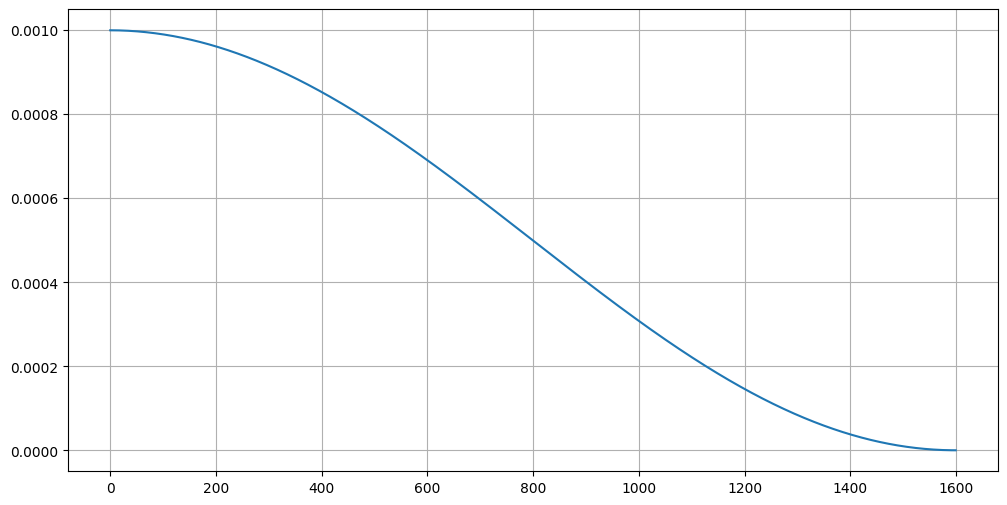

In [24]:
print('Scheduler Type is :', CFG.scheduler_type)
print('First Learning Rate is :', CFG.base_lr)
print('Last Learning Rate is :', history['LR'][-1])
print('Iteration is: ', len(history['LR']))

plt.figure(figsize=(12,6))

plt.plot(history['LR'])

plt.grid(True)
plt.show()

**Train Loss**

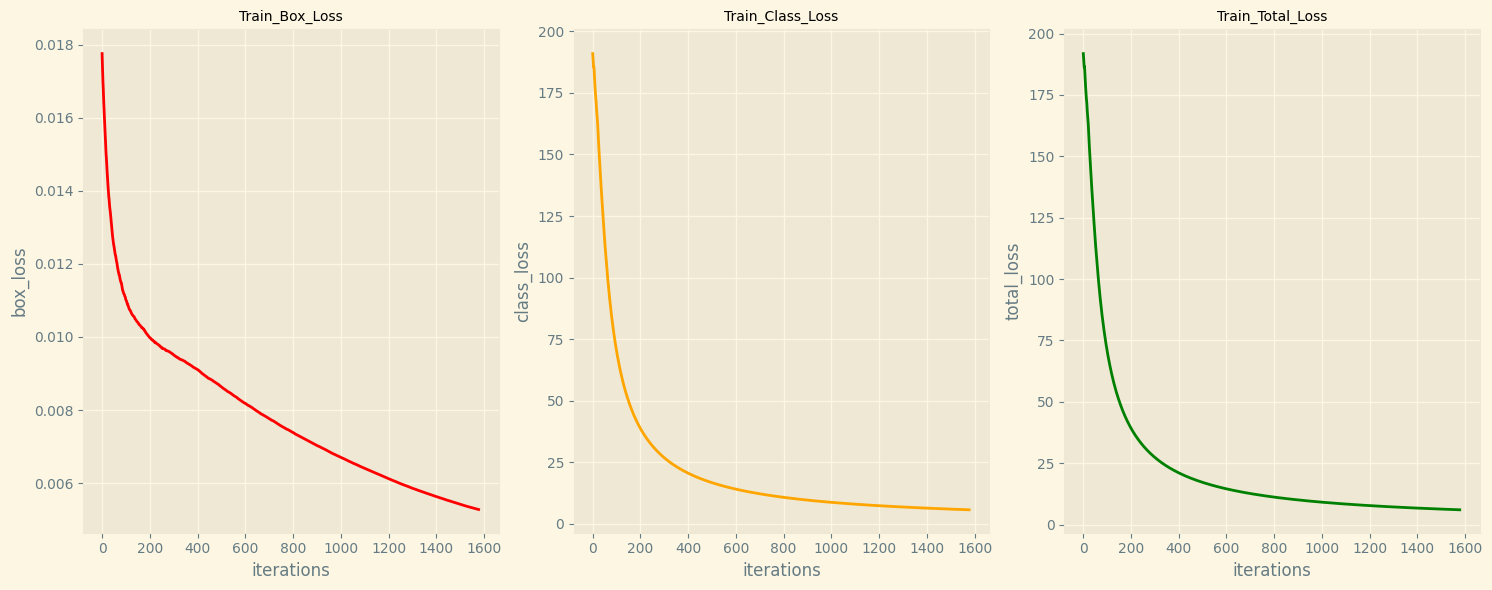

In [25]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title('Train_Box_Loss', size=10)
plt.plot(history['box_loss'][len(train_loader)//5:], color='red')
plt.xlabel('iterations')
plt.ylabel('box_loss')
plt.grid(True)

plt.subplot(1,3,2)
plt.title('Train_Class_Loss', size=10)
plt.plot(history['class_loss'][len(train_loader)//5:], color='orange')
plt.xlabel('iterations')
plt.ylabel('class_loss')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('Train_Total_Loss', size=10)
plt.plot(history['total_loss'][len(train_loader)//5:], color='green')
plt.xlabel('iterations')
plt.ylabel('total_loss')
plt.grid(True)

plt.tight_layout()
plt.show()

**Valid Loss**

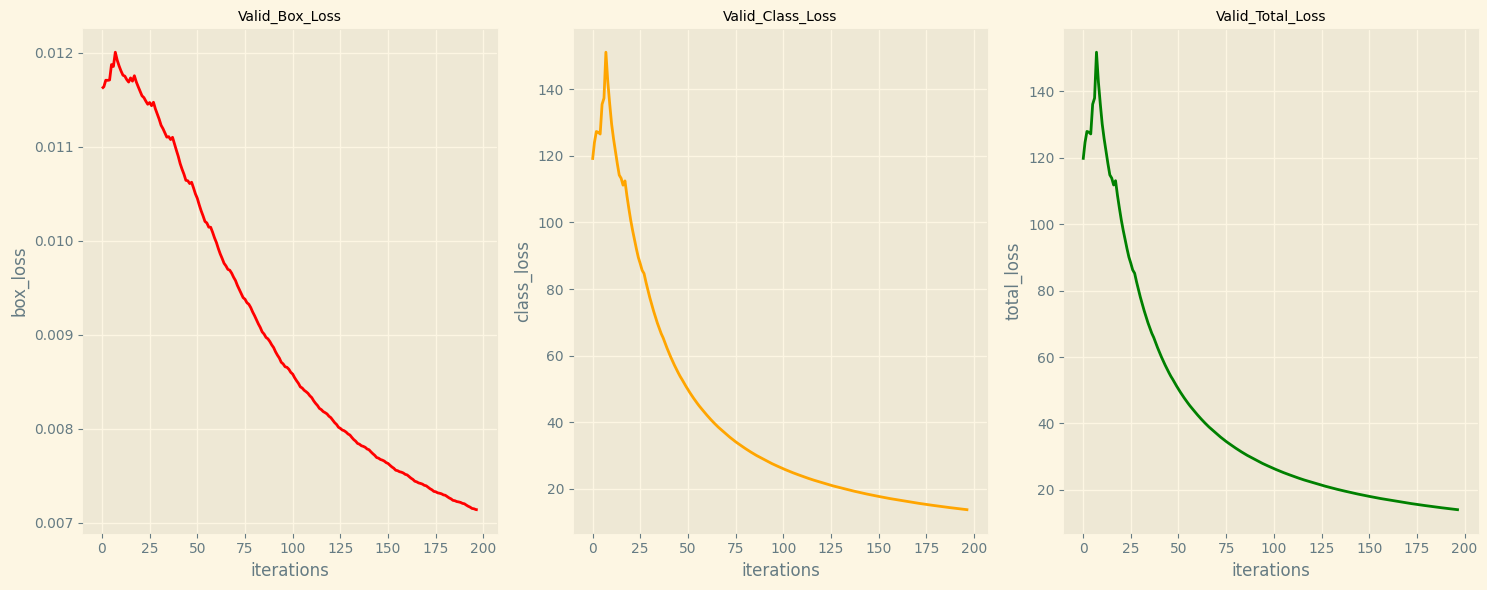

In [26]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title('Valid_Box_Loss', size=10)
plt.plot(history['valid_box_loss'][len(valid_loader)//5:], color='red')
plt.xlabel('iterations')
plt.ylabel('box_loss')
plt.grid(True)

plt.subplot(1,3,2)
plt.title('Valid_Class_Loss', size=10)
plt.plot(history['valid_class_loss'][len(valid_loader)//5:], color='orange')
plt.xlabel('iterations')
plt.ylabel('class_loss')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('Valid_Total_Loss', size=10)
plt.plot(history['valid_total_loss'][len(valid_loader)//5:], color='green')
plt.xlabel('iterations')
plt.ylabel('total_loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
clean_memory()
del train_loader, valid_loader, best_model, history

## 5. Validation
___

1) **Training**: `DetBenchTrain(net, config)` 

2) **Inference**: `DetBenchPredict(net, config)`

In [28]:
def load_net(checkpoint_path):
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes
    config.image_size = CFG.img_size
    config.max_det_per_image = 100

    net = EfficientDet(config, pretrained_backbone=False)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)
    
    net.load_state_dict(torch.load(checkpoint_path))
    
    net = DetBenchPredict(net)

    return net

In [29]:
def format_pred(boxes, scores, labels):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.float32)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

In [30]:
def string_decoder(predict_string):
    s = predict_string.split(' ')
    class_id = [x for x in (s[0::6])]
    score = [x for x in (s[1::6])]
    x_min = [x for x in (s[2::6])]
    y_min = [x for x in (s[3::6])]
    x_max = [x for x in (s[4::6])]
    y_max = [x for x in (s[5::6])]

    return class_id, score, x_min, y_min, x_max, y_max

**Box Format**

1) EfficientDet의 학습 bbox format: `ymin, xmin, ymax, xmax`

2) EfficientDet의 출력 bbox format: `xmin, ymin, xmin, ymin`

In [31]:
def make_predictions(images, score_threshold=0.0):
    images = torch.stack(images).to(CFG.device).float()
    
    net = load_net('/kaggle/working/runs/detect/best-checkpoint.bin')
    net.to(CFG.device)
    net.eval()

    img_info = {}
    img_info['img_scale'] = torch.tensor([1] * images.shape[0], dtype=torch.float).to(CFG.device)
    img_info['img_size'] = torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(CFG.device)

    predictions = []
    with torch.no_grad():
        
        det = net(images, img_info)
        for i in range(images.shape[0]):
            boxes = det[i].cpu().numpy()[:,:4]
            scores = det[i].cpu().numpy()[:,4]
            labels = det[i].cpu().numpy()[:,5].astype('int32')
            
            indexes = np.where(scores >= score_threshold)
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return predictions    

In [32]:
valid_dataset = GastroscopyDataset(
         df = valid_df,
         mode = 'test', 
         image_dir = CFG.imgdir,
         transforms = get_valid_transform()
)

valid_loader = DataLoader(
        valid_dataset,
        batch_size = CFG.valid_bs,
        shuffle = False,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn 
    )

results = []

for images, image_ids in tqdm(valid_loader, total=len(valid_loader)):
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes = predictions[i]['boxes']
        scores = predictions[i]['scores']
        labels = predictions[i]['labels']
        image_id = image_ids[i]

        result = {
             'image_id': image_id,
             'PredictionString': format_pred(boxes, scores, labels)
                 }
        results.append(result)

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


In [33]:
submission_det = pd.DataFrame(results, columns=['image_id','PredictionString'])
print(display(submission_det))

,image_id,PredictionString
0,1_1_00011.png,3 0.4587838649749756 111.30514526367188 105.57...
1,1_1_00019.png,1 0.4648955166339874 0.0 27.26458740234375 157...
2,1_1_00029.png,1 0.43746131658554077 8.476722717285156 11.794...
3,1_1_00042.png,3 0.08478070050477982 103.31291198730469 61.81...
4,1_1_00050.png,3 0.31892967224121094 48.44091033935547 131.88...
...,...,...
313,1_2_04981.png,3 0.32972240447998047 155.90028381347656 121.3...
314,1_2_05214.png,3 0.47241804003715515 35.093605041503906 100.2...
315,1_2_05221.png,3 0.35321852564811707 45.00916290283203 78.653...
316,1_2_05228.png,3 0.45686909556388855 152.23031616210938 106.9...


None


In [34]:
submission_list = []

for i, row in tqdm(submission_det.iterrows(), total=len(submission_det)):
    image_id = row['image_id']
    string_decoded = string_decoder(row['PredictionString'])

    for  (class_id, score, xmin, ymin, xmax, ymax) in zip(*string_decoded):
        submission_list.append(
            {
                'image_id': image_id,
                'lesion_label': int(class_id),
                'score': float(score),
                'x_min': float(xmin),
                'y_min': float(ymin),
                'x_max': float(xmax),
                'y_max': float(ymax),
                }
        )

submission_metric = pd.DataFrame(submission_list, columns=['image_id', 'lesion_label', 'score','x_min','y_min', 'x_max', 'y_max'])

100%|██████████| 318/318 [00:00<00:00, 2653.50it/s]


In [35]:
!pip install map-boxes
from map_boxes import mean_average_precision_for_boxes

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [36]:
ann = valid_df.copy()
det = submission_metric.copy()

ann['lesion_label'] -=1 ; det['lesion_label'] -= 1
ann['x_min'] *= CFG.img_size[0]/ann['width'].values[0]; ann['x_max'] *= CFG.img_size[0]/ann['width'].values[0]
ann['y_min'] *= CFG.img_size[1]/ann['height'].values[0]; ann['y_max'] *= CFG.img_size[1]/ann['height'].values[0]


ann = ann[['image_id','lesion_label','x_min','x_max','y_min','y_max']].values

det = det[['image_id','lesion_label', 'score','x_min','x_max','y_min','y_max']].values

mean_ap_50, average_precisions_50 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.5)
mean_ap_75, average_precisions_75 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.75)

Number of files in annotations: 318
Number of files in predictions: 318
Unique classes: 3
Detections length: 318
Annotations length: 318
0                              | 0.376474 |     101
1                              | 0.235420 |     171
2                              | 0.661473 |     181
mAP: 0.424455
Number of files in annotations: 318
Number of files in predictions: 318
Unique classes: 3
Detections length: 318
Annotations length: 318
0                              | 0.170273 |     101
1                              | 0.050737 |     171
2                              | 0.325938 |     181
mAP: 0.182316
